## Initialization

In [1]:
%load_ext autoreload
%autoreload 2
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib
for d in device_lib.list_local_devices():
    print(d)

1.11.0
name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1878300828826537228

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9425607066
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18395722958917048397
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"



In [3]:
from PIL import Image
import sklearn
from pathlib import Path

/data/intsco/miniconda3/envs/off-smpl/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [4]:
import off_sample_utils as utils

Using TensorFlow backend.


In [5]:
# utils.plot_masks()

In [6]:
gs_path = Path('./GS/raw_images/')

## Prepare Data

In [58]:
def get_ds_paths():
    first_n=50
    ds_to_exlude = ['Row001', 'HK_S2_N2_20um_New', '12_cylces_75um_new_submission',
                    '50um_min(focusing)_high(m_z)_dry(application)', '100um_noM2_001_Recal', '50%meoh_8cyc_75um',
                    'Servier_Ctrl_mouse_wb_lateral_plane_DHB', 'North Carolina State University__mouse body',
                    '75um_small(focusing)_high(m_z)_dry(application)', 'Servier_Ctrl_rat_liver_9aa']
    all_paths = [p for p in list(gs_path.iterdir())[:first_n] if p.name not in ds_to_exlude]
    return all_paths
    len(all_paths)

In [8]:
# ds_to_exlude = ['Row001', 'HK_S2_N2_20um_New', '12_cylces_75um_new_submission']
# ds_paths = [p for p in list(gs_path.iterdir())[:10] if p.name not in ds_to_exlude]
# test_ds_paths = [p for p in list(gs_path.iterdir())[10:20] if p.name not in ds_to_exlude]
# all_paths = ds_paths + test_ds_paths
# len(ds_paths), len(test_ds_paths)

In [9]:
ds_names = [p.name for p in all_paths]
ds_names = np.array(ds_names)
ds_names

array(['Tumor11', 'ICL__LNTO30_16_1', 'Tumor41', '161007_WT1S1L1',
       'UoNotreDame__Untreated_6_574', 'Kidney_280x140_40um_E0',
       'Dataset 16', 'Esco1_centroids', 'Xenograft_3_135um',
       'DESI porcine kidney interface region', 'MPIMM_049_QE_P_BA_CF_sp3',
       'Dataset 4_recal', 'ICL__LNTO41_17_2',
       'S649 WS21 155x105 15um E110', 'Dataset 23', 'Dataset 3',
       'ST-Pseudo_centroids', 'Dataset 18', 'ICL__A51 CT S3-centroid',
       'Tumor17',
       'MS7_20170907_DHB_pos_MouseBrain_s3_300-1800_40um_245x134_A30-JBE-Test',
       'MPIMM_021_QE_P_CB_0', 'Rat50_Section1',
       '20170503_ADP-JS_CD1-Brain_dan005_117x143_60x60_N',
       'Dataset 3_recal', '20170815_CGL_MT-M.B_DAN012_NTM_42x30_100x100',
       'ICL__LNTO42_17_1',
       '170321_kangaroobrain-bpyn1-pos_maxof50.0_med1r',
       'Mousebrain_MG08_2017_GruppeA',
       '75um_small(focusing)_low(m_z)_dry(application)', 'Dataset 30',
       '70%meoh_8cyc_75um', 'Dataset 31', 'ICL__LNTO22_1_3', 'Dataset 2',
   

In [10]:
# all_ions = utils.create_ion_list(all_paths)
# ds_name = all_paths[0].name
ds_name = 'S649 WS21 155x105 15um E110'
valid_paths = [gs_path / ds_name]
train_paths = [p for p in all_paths if p not in valid_paths]
valid_paths, len(train_paths)

([PosixPath('GS/raw_images/S649 WS21 155x105 15um E110')], 39)

In [49]:
masks = {p.name: utils.load_mask(p) for p in all_paths}
ions = utils.create_ion_list(train_paths)
len(ions)

6584

In [50]:
X_train, y_train, groups_train = utils.prepare_pixel_xygroups(train_paths, masks, ions)
X_valid, y_valid, groups_valid = utils.prepare_pixel_xygroups(valid_paths, masks, ions)
X_train.shape, X_valid.shape

((739604, 6584), (16275, 6584))

## Train Model

In [51]:
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential
from keras import Model
from keras.wrappers.scikit_learn import KerasClassifier

def create_build_model(feature_n):
    def build_model():
        model_in = Input(shape=(feature_n,))
        out = Dense(256, activation='relu')(model_in)
        out = Dropout(0.75)(out)
#         out = Dense(64, activation='relu')(out)
#         out = Dropout(0.75)(out)
#         out = Dense(64, activation='relu')(out)
#         out = Dropout(0.75)(out)
        out = Dense(10, activation='relu')(out)
        out = Dropout(0.75)(out)
        out = Dense(1, activation='sigmoid')(out)
        model = Model(model_in, out)
        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['binary_accuracy'])
        return model
    return build_model

In [55]:
model = KerasClassifier(create_build_model(feature_n=X_train.shape[-1]),
                        batch_size=64, epochs=5, verbose=1)
model.fit(X_train.tocsr(), y_train)
y_prob = model.predict_proba(X_valid.tocsr())[:,1]

16275/16275 [==============================] - 1s 44us/step


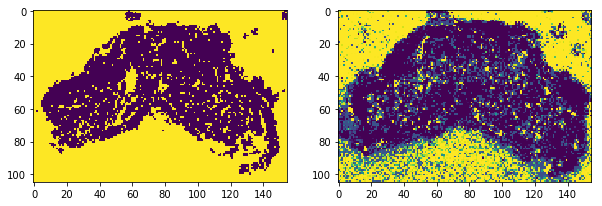

In [56]:
mask = masks[ds_name]
prob_mask = y_prob.reshape(mask.shape)
utils.plot_masks(mask, [prob_mask])

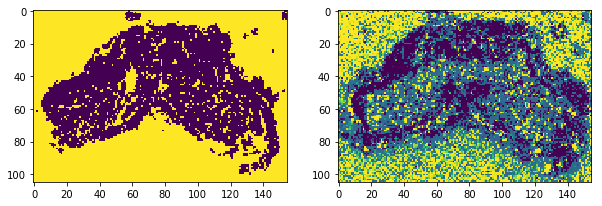

In [92]:
mask = masks[ds_name]
prob_mask = y_prob.reshape(mask.shape)
utils.plot_masks(mask, [prob_mask])

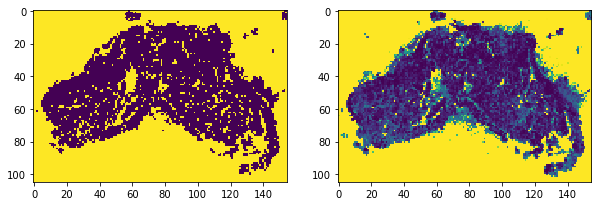

In [70]:
mask = masks[ds_name]
prob_mask = y_prob.reshape(mask.shape)
utils.plot_masks(mask, [prob_mask])

In [71]:
layer = model.model.layers[-3]

In [72]:
interm_layer_model = Model(inputs=model.model.input, outputs=layer.output)

In [73]:
interm_output = interm_layer_model.predict(X_valid)

In [74]:
img = interm_output.reshape(mask.shape + (-1,))
img.shape

(105, 155, 10)

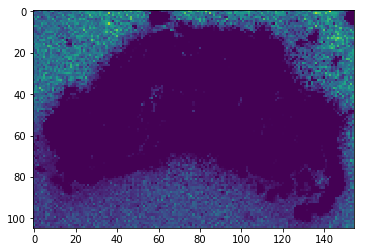

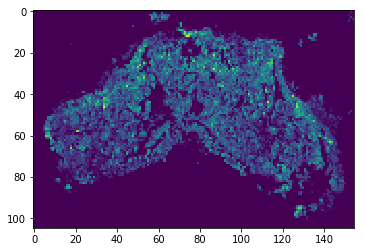

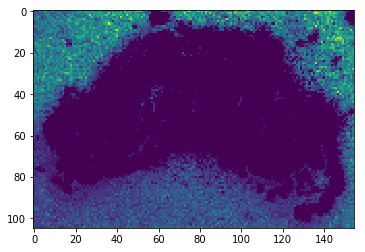

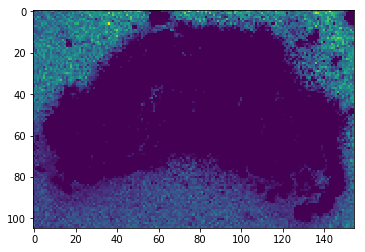

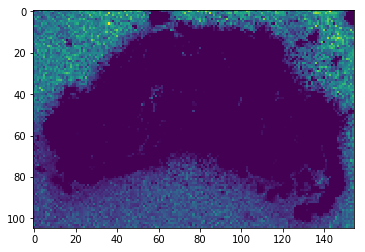

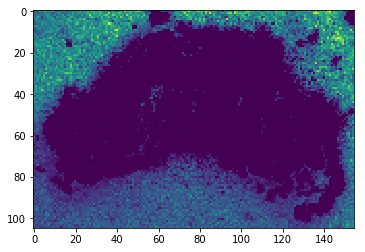

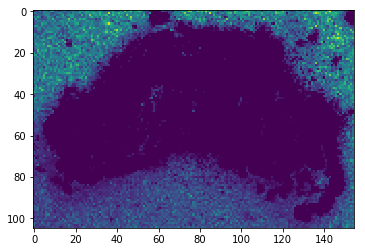

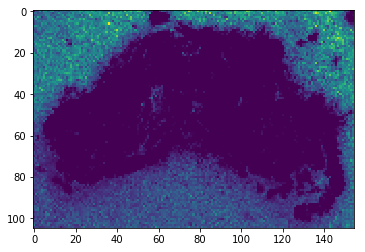

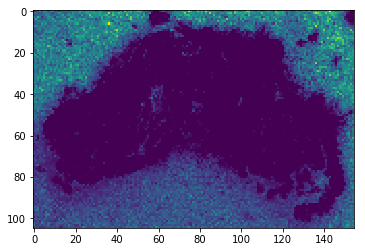

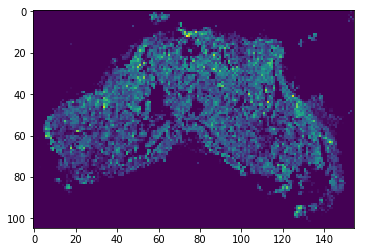

In [75]:
for ch in range(img.shape[-1]):
    plt.imshow(img[:,:,ch])
    plt.show()

## Compare Dataset Ion Sets

In [61]:
gs_rect_path = Path('GS/raw_images_rect')

In [59]:
all_paths = get_ds_paths()
len(all_paths)

40

In [60]:
def train_ion_coverage(valid_ions, train_ions):
     return (len(valid_ions),
             len(train_ions),
             len(set(valid_ions) & set(train_ions)) / len(valid_ions))

In [21]:
# for valid_path in all_paths:
#     train_paths = [p for p in all_paths if p != valid_path]
#     train_ions = utils.create_ion_list(train_paths)
#     valid_ions = utils.create_ion_list(valid_path)
#     print(valid_path)
#     print(train_ion_coverage(valid_ions, train_ions))
#     print()

In [23]:
ds_ion_sets = {}
for ds_path in all_paths:
    ds_ion_sets[ds_path.name] = utils.create_ion_list(ds_path)

In [24]:
ds_name = 'S649 WS21 155x105 15um E110'
ds_path = gs_path / ds_name
valid_ions = ds_ion_sets[ds_name]
len(valid_ions)

422

In [25]:
train_paths = [p for p in all_paths if p != ds_path]
print(len(train_paths))
train_ions = utils.create_ion_list(train_paths)
train_ion_coverage(valid_ions, train_ions)

39


(422, 6584, 0.4597156398104265)

In [65]:
all_gs_paths = list(gs_path.iterdir())
len(all_gs_paths)

86

In [66]:
ion_coverage = {}
for valid_path in all_gs_paths:
    train_paths = [p for p in all_gs_paths if p != valid_path]
    train_ions = utils.create_ion_list(train_paths)
    valid_ions = utils.create_ion_list(valid_path)
    cov = train_ion_coverage(valid_ions, train_ions)
    ion_coverage[valid_path.name] = cov

In [67]:
sorted(ion_coverage.items(), key=lambda t: t[1][-1], reverse=True)

[('ICL__LNTO30_16_1', (70, 11014, 1.0)),
 ('50um_min(focusing)_high(m_z)_dry(application)', (10, 11014, 1.0)),
 ('ICL__LNTO31_17_4', (202, 11014, 1.0)),
 ('LNTO31_17_1-RECAL', (158, 11012, 0.9873417721518988)),
 ('ICL__LNTO41_17_2', (183, 11010, 0.9781420765027322)),
 ('ICL__LNTO41_17_4', (245, 11007, 0.9714285714285714)),
 ('ICL__LNTO26_7_3', (212, 11006, 0.9622641509433962)),
 ('75um_small(focusing)_high(m_z)_dry(application)',
  (97, 11010, 0.9587628865979382)),
 ('Servier_Ctrl_mouse_wb_median_plane_DHB', (304, 10996, 0.9407894736842105)),
 ('50%meoh_8cyc_75um', (338, 10993, 0.9378698224852071)),
 ('ICL__LNTO42_17_1', (274, 10996, 0.9343065693430657)),
 ('Tumor41', (91, 11008, 0.9340659340659341)),
 ('ICL__7TopRight,_17BottomRight,_27BottomLeft,_37TopLeft',
  (315, 10990, 0.9238095238095239)),
 ('161007_WT1S1L1', (184, 10999, 0.9184782608695652)),
 ('Borderline14', (147, 11002, 0.9183673469387755)),
 ('Tumor17', (180, 10998, 0.9111111111111111)),
 ('Dataset 4', (262, 10989, 0.904580